# CGNet
Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [6]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [7]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [9]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [10]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [11]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10),
                    ],p=1)

In [12]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [13]:
transforms2=Compose([],p=1)

In [14]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [15]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [16]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [17]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [18]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [19]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

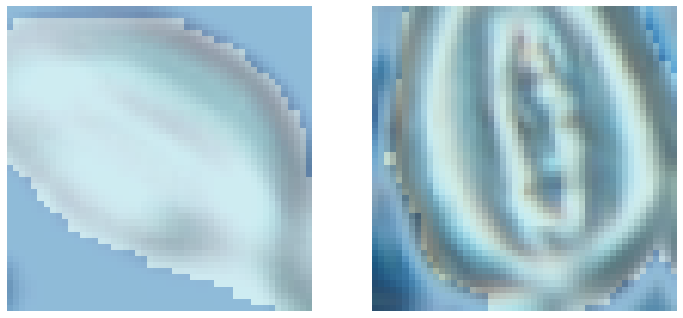

In [23]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [24]:
from architectures import CGNet
model = CGNet(nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [25]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/CGNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

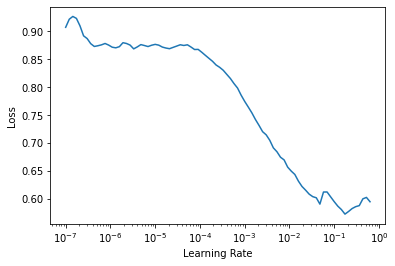

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.301668,0.284673,0.927130,0.864158,09:07
1,0.263745,0.258485,0.932879,0.874201,09:09
2,0.262652,0.239036,0.938677,0.884440,09:04
3,0.250395,0.227311,0.941023,0.888615,09:02
4,0.231087,0.221445,0.942044,0.890439,09:02
5,0.243496,0.208325,0.945285,0.896246,09:08
6,0.245309,0.201080,0.947831,0.900836,09:08
7,0.202317,0.195253,0.949219,0.903347,09:05
8,0.214484,0.193232,0.949659,0.904143,09:03
9,0.218716,0.196814,0.948838,0.902656,09:13


Better model found at epoch 0 with valid_loss value: 0.2846734821796417.


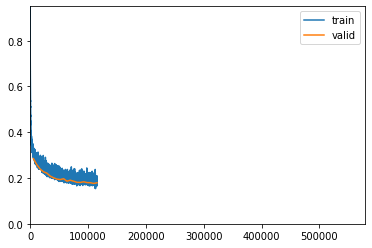

Better model found at epoch 1 with valid_loss value: 0.25848522782325745.
Better model found at epoch 2 with valid_loss value: 0.2390361875295639.
Better model found at epoch 3 with valid_loss value: 0.22731119394302368.
Better model found at epoch 4 with valid_loss value: 0.22144542634487152.
Better model found at epoch 5 with valid_loss value: 0.20832514762878418.
Better model found at epoch 6 with valid_loss value: 0.20107997953891754.
Better model found at epoch 7 with valid_loss value: 0.19525296986103058.
Better model found at epoch 8 with valid_loss value: 0.19323214888572693.
Better model found at epoch 10 with valid_loss value: 0.1862277388572693.
Better model found at epoch 12 with valid_loss value: 0.18602091073989868.
Better model found at epoch 13 with valid_loss value: 0.18123756349086761.
Better model found at epoch 14 with valid_loss value: 0.1807115525007248.
Better model found at epoch 16 with valid_loss value: 0.1800987720489502.
Better model found at epoch 17 with v

In [ ]:
name = "model_CGNet_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1763547956943512,0.9540942011751878,0.9122181005662416]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

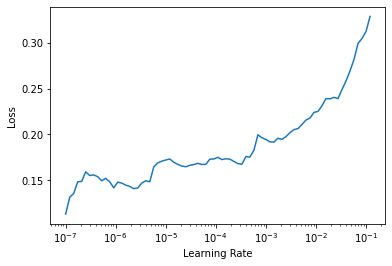

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.187480,0.172540,0.955160,0.914168,09:03
1,0.190994,0.171097,0.955119,0.914094,09:11
2,0.155113,0.171412,0.955330,0.914480,09:23
3,0.177527,0.169865,0.955617,0.915007,09:23
4,0.175727,0.171285,0.955174,0.914194,09:20
5,0.174114,0.170528,0.955330,0.914480,09:22


Better model found at epoch 0 with valid_loss value: 0.17254026234149933.


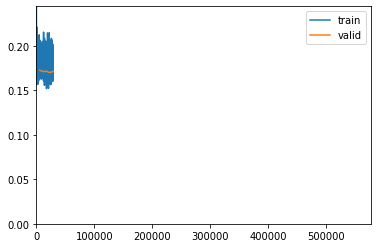

Better model found at epoch 1 with valid_loss value: 0.17109668254852295.
Better model found at epoch 3 with valid_loss value: 0.16986528038978577.
No improvement since epoch 3: early stopping


In [ ]:
name = "model_CGNet_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.16986528038978577,0.9556171534934542,0.9150065578824736]



---


Definición del modelo.

In [26]:
del model, learn
model = CGNet(nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [27]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/CGNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

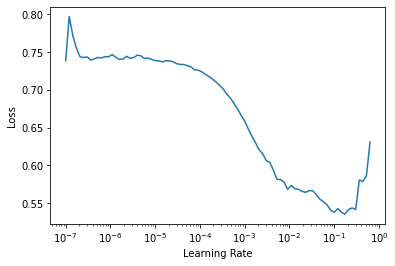

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.305175,0.291393,0.924727,0.859994,09:36
1,0.258762,0.254584,0.934238,0.876591,09:41
2,0.254393,0.246906,0.935581,0.878959,09:42
3,0.240874,0.230483,0.940110,0.886988,09:40
4,0.237596,0.221548,0.942100,0.890538,09:41
5,0.209514,0.213127,0.944188,0.894277,09:42
6,0.217937,0.207004,0.946347,0.898158,09:47
7,0.215372,0.198160,0.948594,0.902214,09:47
8,0.207023,0.197413,0.948435,0.901928,09:46
9,0.193473,0.191177,0.950380,0.905451,10:02


Better model found at epoch 0 with valid_loss value: 0.29139307141304016.


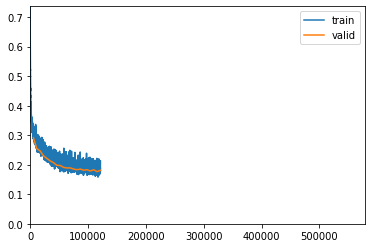

Better model found at epoch 1 with valid_loss value: 0.2545836865901947.
Better model found at epoch 2 with valid_loss value: 0.24690592288970947.
Better model found at epoch 3 with valid_loss value: 0.23048339784145355.
Better model found at epoch 4 with valid_loss value: 0.22154754400253296.
Better model found at epoch 5 with valid_loss value: 0.2131272703409195.
Better model found at epoch 6 with valid_loss value: 0.2070041447877884.
Better model found at epoch 7 with valid_loss value: 0.19815991818904877.
Better model found at epoch 8 with valid_loss value: 0.19741345942020416.
Better model found at epoch 9 with valid_loss value: 0.19117669761180878.
Better model found at epoch 10 with valid_loss value: 0.18903383612632751.
Better model found at epoch 12 with valid_loss value: 0.18541765213012695.
Better model found at epoch 13 with valid_loss value: 0.18320660293102264.
Better model found at epoch 15 with valid_loss value: 0.1814640611410141.
Better model found at epoch 17 with va

In [ ]:
name = "model_CGNet_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17660246789455414,0.9536133142798284,0.9113393043829755]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Recorder

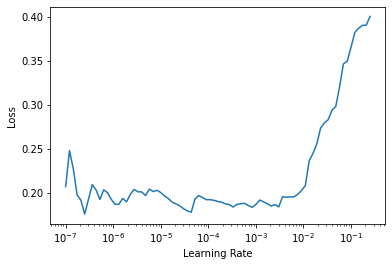

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.178490,0.170429,0.955353,0.914523,09:03
1,0.164119,0.170014,0.955496,0.914785,09:13
2,0.186061,0.169887,0.955550,0.914883,09:25
3,0.167471,0.168549,0.955855,0.915443,09:16
4,0.192481,0.170090,0.955664,0.915093,09:16
5,0.172793,0.170054,0.955197,0.914237,09:15


Better model found at epoch 0 with valid_loss value: 0.17042924463748932.


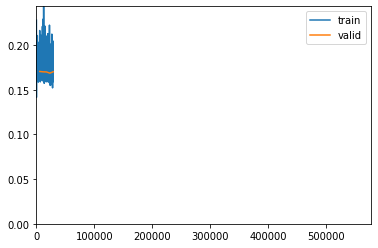

Better model found at epoch 1 with valid_loss value: 0.17001397907733917.
Better model found at epoch 2 with valid_loss value: 0.16988660395145416.
Better model found at epoch 3 with valid_loss value: 0.168548583984375.
No improvement since epoch 3: early stopping


In [ ]:
name = "model_CGNet_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.168548583984375,0.9558549090363219,0.9154426116720328]

# Modelos sin aumento de datos
Definición del modelo.

In [ ]:
del model, learn
model = CGNet(nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/CGNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

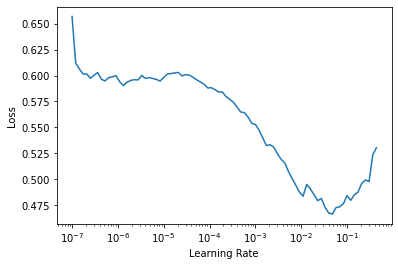

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.303372,0.283341,0.926500,0.863064,09:19
1,0.279186,0.254248,0.934507,0.877066,09:08
2,0.271750,0.242456,0.936875,0.881247,09:04
3,0.247391,0.228426,0.940433,0.887564,09:19
4,0.227815,0.219077,0.943238,0.892575,09:09
5,0.225676,0.212840,0.944290,0.894460,09:13
6,0.215823,0.203729,0.946889,0.899135,09:13
7,0.250891,0.197695,0.948708,0.902422,09:07
8,0.203784,0.199390,0.947882,0.900927,09:10
9,0.219844,0.194913,0.949463,0.903788,08:59


Better model found at epoch 0 with valid_loss value: 0.2833414077758789.


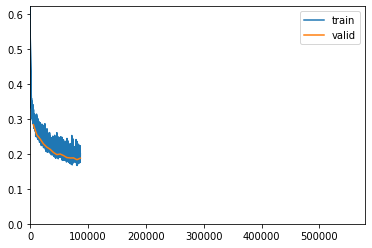

Better model found at epoch 1 with valid_loss value: 0.25424817204475403.
Better model found at epoch 2 with valid_loss value: 0.24245624244213104.
Better model found at epoch 3 with valid_loss value: 0.22842560708522797.
Better model found at epoch 4 with valid_loss value: 0.21907663345336914.
Better model found at epoch 5 with valid_loss value: 0.21284043788909912.
Better model found at epoch 6 with valid_loss value: 0.20372895896434784.
Better model found at epoch 7 with valid_loss value: 0.19769525527954102.
Better model found at epoch 9 with valid_loss value: 0.1949128806591034.
Better model found at epoch 10 with valid_loss value: 0.1892351359128952.
Better model found at epoch 11 with valid_loss value: 0.18814124166965485.
Better model found at epoch 13 with valid_loss value: 0.18318018317222595.
No improvement since epoch 13: early stopping


In [ ]:
name = "model_CGNet_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18318018317222595,0.9522162723596321,0.9087908575408442]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

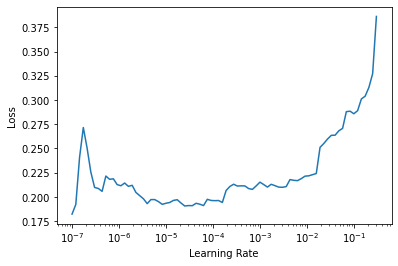

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.187605,0.180334,0.953292,0.910753,09:11
1,0.182198,0.178426,0.953579,0.911277,09:07
2,0.184296,0.179514,0.953476,0.911089,09:14
3,0.194850,0.178819,0.953581,0.911280,09:18


Better model found at epoch 0 with valid_loss value: 0.18033449351787567.


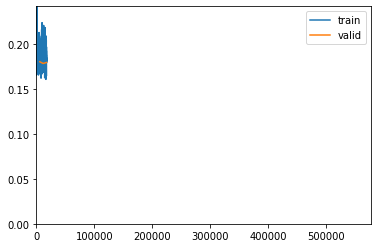

Better model found at epoch 1 with valid_loss value: 0.17842572927474976.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_CGNet_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17842572927474976,0.9535792622855341,0.9112771067288757]



---


Definición del modelo.

In [ ]:
del model, learn
model = CGNet(nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/CGNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

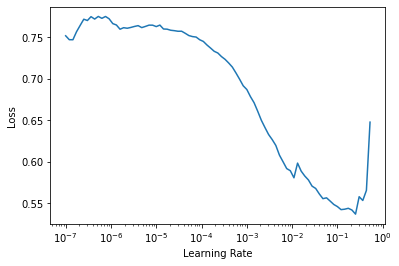

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

Better model found at epoch 1 with valid_loss value: 0.25598451495170593.
Better model found at epoch 2 with valid_loss value: 0.2400670200586319.
Better model found at epoch 3 with valid_loss value: 0.23106449842453003.
Better model found at epoch 4 with valid_loss value: 0.21948233246803284.
Better model found at epoch 5 with valid_loss value: 0.20855660736560822.
Better model found at epoch 6 with valid_loss value: 0.20359766483306885.
Better model found at epoch 7 with valid_loss value: 0.20255374908447266.
Better model found at epoch 8 with valid_loss value: 0.19216102361679077.
Better model found at epoch 9 with valid_loss value: 0.19192835688591003.
Better model found at epoch 11 with valid_loss value: 0.19127722084522247.
Better model found at epoch 12 with valid_loss value: 0.18777577579021454.


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.312155,0.282408,0.926609,0.863254,09:18
1,0.274158,0.255985,0.933879,0.875959,09:19
2,0.255985,0.240067,0.937833,0.882942,09:18
3,0.268567,0.231064,0.939795,0.886428,09:21
4,0.224512,0.219482,0.942816,0.891818,09:20
5,0.234033,0.208557,0.945296,0.896268,09:21
6,0.226019,0.203598,0.947058,0.899440,09:18
7,0.214177,0.202554,0.948210,0.901521,09:02
8,0.222670,0.192161,0.949872,0.904530,09:06
9,0.209871,0.191928,0.950043,0.904840,09:06


Better model found at epoch 13 with valid_loss value: 0.1851174384355545.


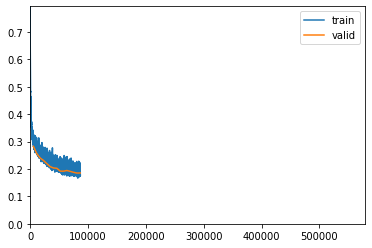

No improvement since epoch 13: early stopping


In [ ]:
name = "model_CGNet_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1851174384355545,0.9520350577054453,0.9084607884123799]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Recorder

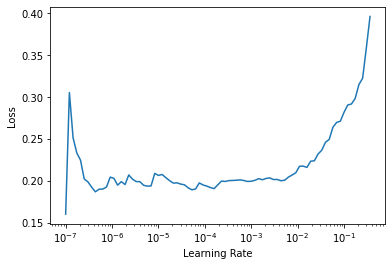

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.185200,0.178847,0.953088,0.910381,14:59
1,0.185327,0.179732,0.953216,0.910613,15:17
2,0.177901,0.180492,0.953035,0.910284,15:11


Better model found at epoch 0 with valid_loss value: 0.17884673178195953.


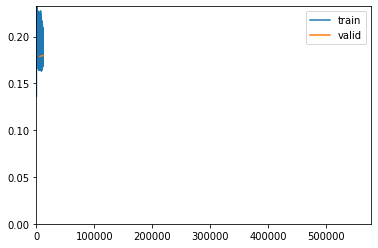

No improvement since epoch 0: early stopping


In [ ]:
name = "model_CGNet_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_CGNet_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17884673178195953,0.9530884415766298,0.9103810478623081]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_CGNet_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.163095161318779,0.957774690312555,0.9189708611085102]

Comparación de resultado buscado contra resultado obtenido.

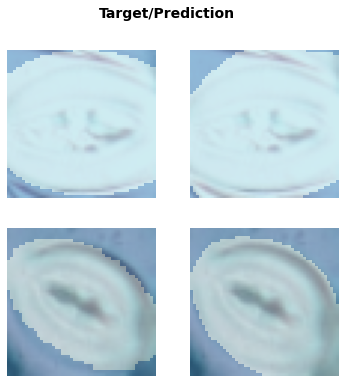

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_CGNet_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1597212851047516,0.9584485228528489,0.9202123408034287]

Comparación de resultado buscado contra resultado obtenido.

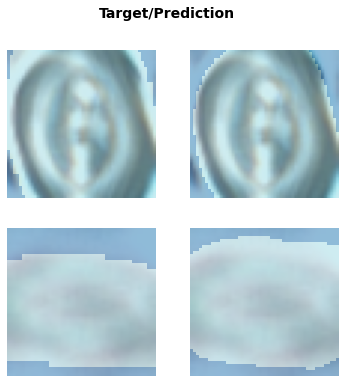

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_CGNet_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.163747638463974,0.9573770439908761,0.9182389841630324]

Comparación de resultado buscado contra resultado obtenido.

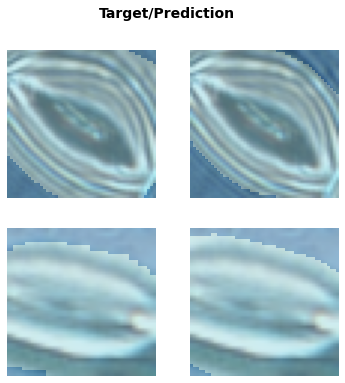

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_CGNet_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.15856806933879852,0.9590609255918567,0.9213420354473283]

Comparación de resultado buscado contra resultado obtenido.

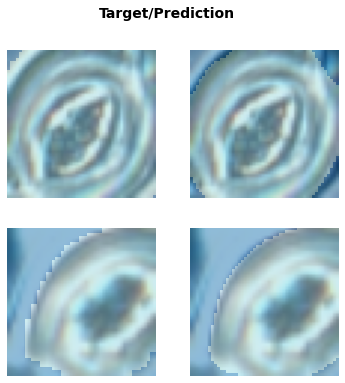

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_CGNet_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16764050722122192,0.9566320813393693,0.9168693652833374]

Comparación de resultado buscado contra resultado obtenido.

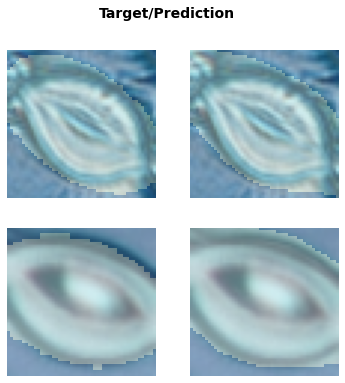

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_CGNet_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1643211841583252,0.9573991624138032,0.9182796789520615]

Comparación de resultado buscado contra resultado obtenido.

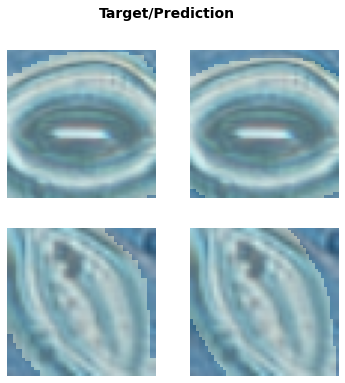

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_CGNet_wd1")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.17004704475402832,0.956586073257264,0.9167848432342419]

Comparación de resultado buscado contra resultado obtenido.

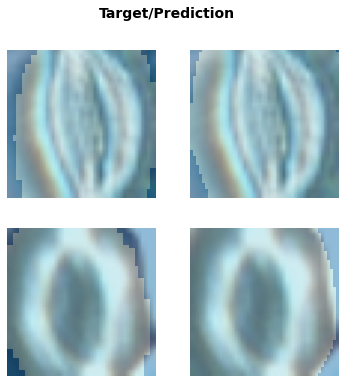

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_CGNet_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16369038820266724,0.9578183764770063,0.9190513005201477]

Comparación de resultado buscado contra resultado obtenido.

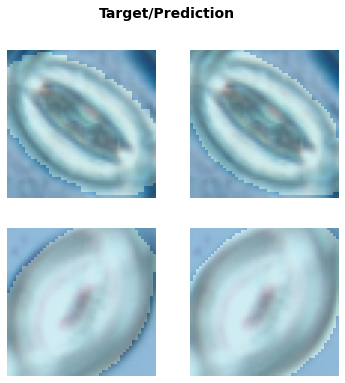

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [28]:
learn.load("model_CGNet_da_wd1_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.15856808423995972,0.9590609255918567,0.9213420354473283]

In [29]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [30]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/CGNet/model_CGNet.pkl")